#**Project Description**

This mini-project will solve a problem with detecting disaster tweets via Twitter by developing a deep learning solution that can intelligently detect these tweets without any human intervention. To introduce the problem of NLP disaster tweet detection, this problem is mainly about identifying tweets as statements or posts in Twitter that contain disaster news. The mini-project's methodology contains a deep learning solution that will consist of the following steps: Importing Machine Learning/Deep Learning Libraries, Data Collection and Pre-Processing, Exploratory Data Analysis (EDA), Deep Learning Model Building and Architecture, Training-and-Testing Data Split, Feature Engineering, Prediction, Performance Evaluation, and Conclusion. Finally, this mini-project will be submitted for peer-review upon its completion.

#**Import Libraries/Frameworks**

In [27]:
!pip3 install kaggle scikit-learn numpy pandas matplotlib nltk seaborn tensorflow scikit-learn

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import os
from google.colab import files
import zipfile
import cv2
import random
import pickle
import shutil

In [3]:
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nezarhindi","key":"3f9a7fb5a85d93a657245e230d84a65d"}'}

In [4]:
# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions to avoid warnings
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 729kB/s]
100% 593k/593k [00:00<00:00, 729kB/s]


In [6]:
print(os.listdir())

# Unzip the dataset
with zipfile.ZipFile("nlp-getting-started.zip", "r") as zip_ref:
    zip_ref.extractall("nlp-getting-started")

# Verify extraction
os.listdir("nlp-getting-started")

['.config', 'nlp-getting-started.zip', 'sample_data']


['train.csv', 'test.csv', 'sample_submission.csv']

#**Exploratory Data Analysis (EDA)**

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Load training and testing datasets
train_df = pd.read_csv('./nlp-getting-started/train.csv')
test_df = pd.read_csv('./nlp-getting-started/test.csv')

# Display first few rows of training data
print(train_df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [18]:
# Check dataset shape
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Check columns and missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in testing data:")
print(test_df.isnull().sum())

Training data shape: (7613, 5)
Testing data shape: (3263, 4)

Missing values in training data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in testing data:
id             0
keyword       26
location    1105
text           0
dtype: int64


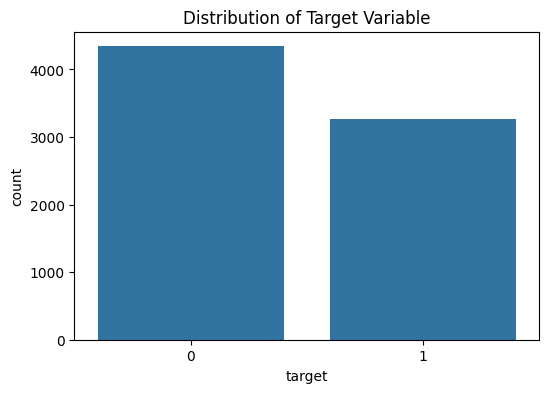

Class Ratio:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


In [19]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Calculate class ratio
class_ratio = train_df['target'].value_counts(normalize=True)
print(f"Class Ratio:\n{class_ratio}")

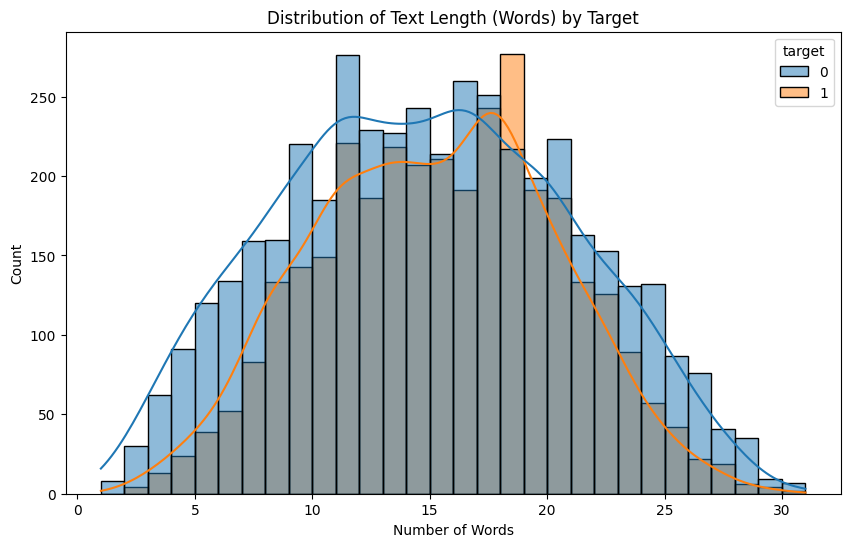

In [20]:
# Calculate text length (number of words)
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', hue='target', kde=True, bins=30)
plt.title('Distribution of Text Length (Words) by Target')
plt.xlabel('Number of Words')
plt.show()

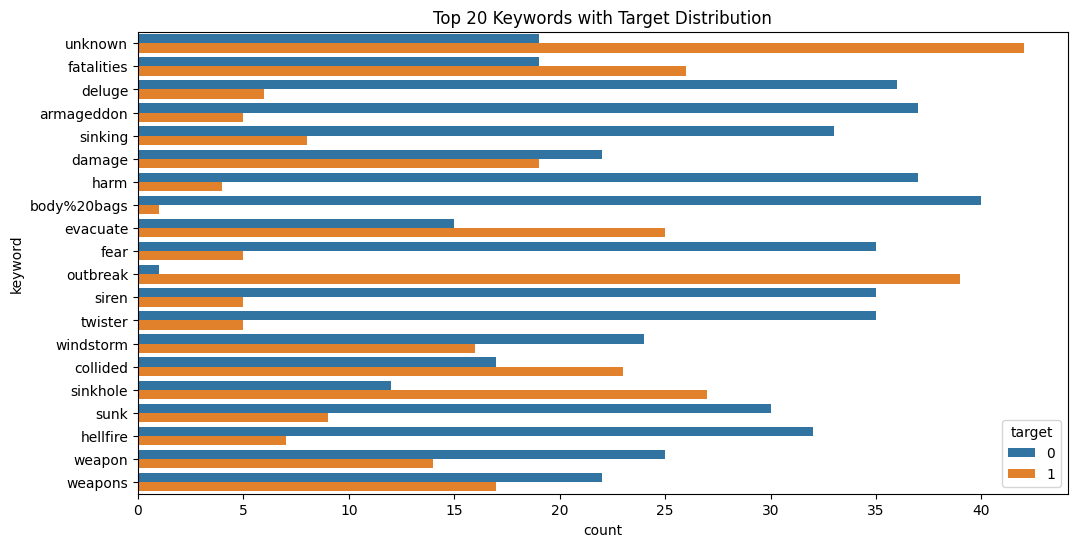

In [21]:
# Fill missing keywords with 'unknown'
train_df['keyword'] = train_df['keyword'].fillna('unknown')

# Plot top 20 keywords with target distribution
plt.figure(figsize=(12, 6))
top_keywords = train_df['keyword'].value_counts().head(20).index
sns.countplot(y='keyword', data=train_df, order=top_keywords, hue='target')
plt.title('Top 20 Keywords with Target Distribution')
plt.show()

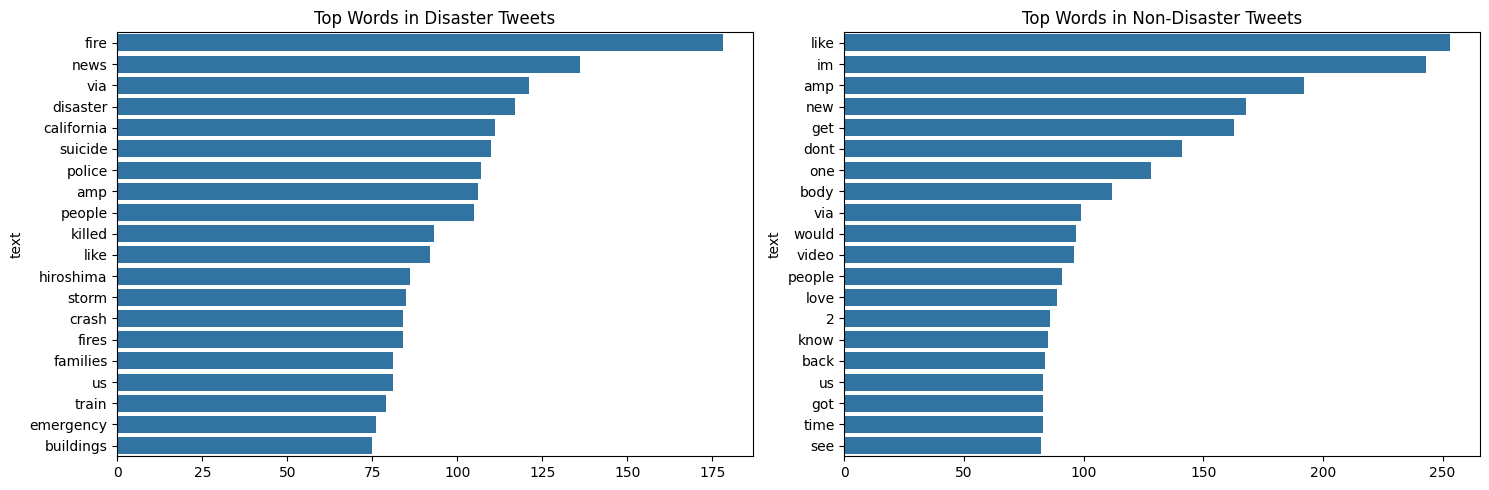

In [22]:
def preprocess_text(text):
    # Lowercase, remove punctuation, and stopwords
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return words

# Get words for each class
disaster_words = train_df[train_df['target'] == 1]['text'].apply(preprocess_text).explode()
non_disaster_words = train_df[train_df['target'] == 0]['text'].apply(preprocess_text).explode()

# Count top 20 words
top_disaster = pd.Series(disaster_words).value_counts().head(20)
top_non_disaster = pd.Series(non_disaster_words).value_counts().head(20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(y=top_disaster.index, x=top_disaster.values, ax=axes[0])
axes[0].set_title('Top Words in Disaster Tweets')
sns.barplot(y=top_non_disaster.index, x=top_non_disaster.values, ax=axes[1])
axes[1].set_title('Top Words in Non-Disaster Tweets')
plt.tight_layout()
plt.show()

In [23]:
# Check duplicates in training data
train_duplicates = train_df.duplicated(subset='text').sum()
print(f"Duplicate tweets in training data: {train_duplicates}")

# Check if test data overlaps with training data
common_texts = set(train_df['text']).intersection(set(test_df['text']))
print(f"Common texts in train and test: {len(common_texts)}")

Duplicate tweets in training data: 110
Common texts in train and test: 68


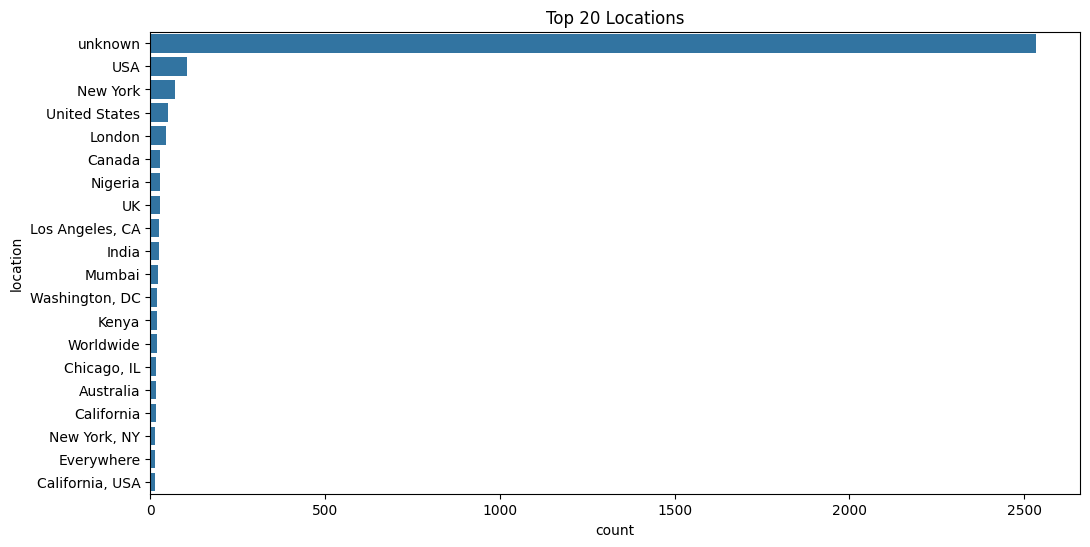

In [24]:
# Fill missing locations and plot top locations
train_df['location'] = train_df['location'].fillna('unknown')
plt.figure(figsize=(12, 6))
top_locations = train_df['location'].value_counts().head(20).index
sns.countplot(y='location', data=train_df, order=top_locations)
plt.title('Top 20 Locations')
plt.show()

#**Data Pre-Processing**

In [28]:
# Preprocess text (lowercase, remove punctuation)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

#**Feature Engineering**

In [29]:
# Split training data into features and labels
X = train_df['clean_text'].values
y = train_df['target'].values

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#**Tokenization and Padding**

In [30]:
# Tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to ensure uniform length
maxlen = 50  # Based on EDA text length analysis
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

#**Model Architecture**

In [31]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_padded, y_val),
    verbose=1
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.6346 - loss: 0.6314 - val_accuracy: 0.7636 - val_loss: 0.4926
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8620 - loss: 0.3460 - val_accuracy: 0.7787 - val_loss: 0.4908
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9221 - loss: 0.2212 - val_accuracy: 0.7807 - val_loss: 0.5349
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9511 - loss: 0.1435 - val_accuracy: 0.7840 - val_loss: 0.6068
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9665 - loss: 0.1012 - val_accuracy: 0.7866 - val_loss: 0.6219
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9787 - loss: 0.0671 - val_accuracy: 0.7400 - val_loss: 0.7390
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9761 - loss: 0.0666 - val_accuracy: 0.7827 - val_loss: 1.0632
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9774 - loss: 0.0555 - val_accuracy: 0.7728 - 

#**Model Evaluation with Results**

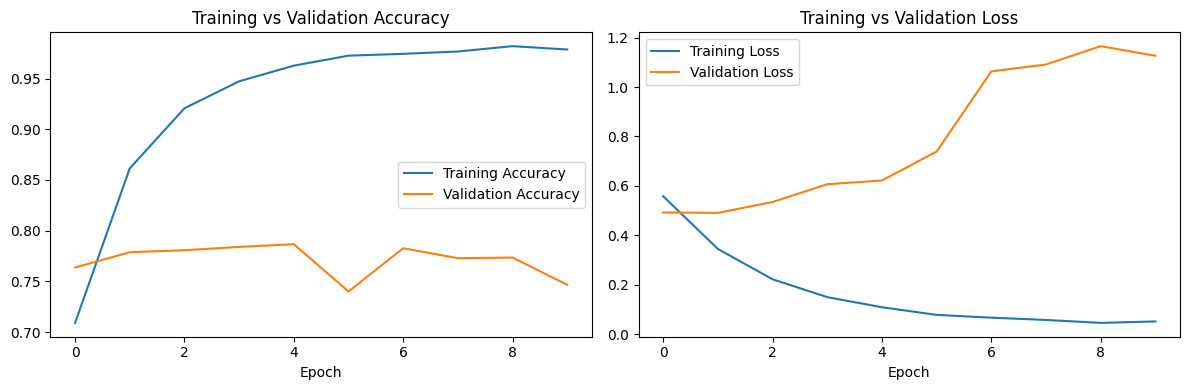

In [33]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       874
           1       0.68      0.77      0.72       649

    accuracy                           0.75      1523
   macro avg       0.74      0.75      0.74      1523
weighted avg       0.75      0.75      0.75      1523



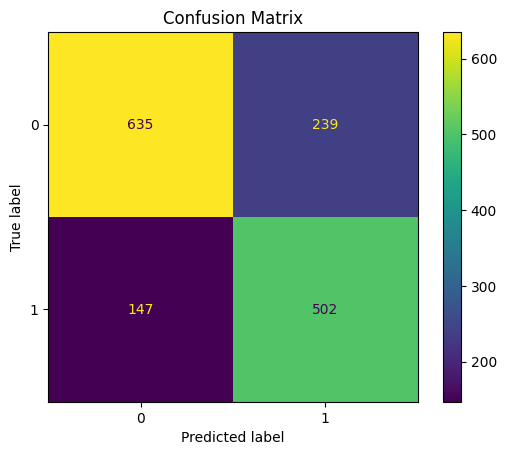

In [34]:
# Predict on validation set
y_val_pred = (model.predict(X_val_padded) > 0.5).astype(int)

# Classification report
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Predict on test data
test_predictions = (model.predict(X_test_padded) > 0.5).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],          # Use the 'id' column from test data
    'target': test_predictions.flatten()  # Flatten predictions to 1D array
})

# Save to CSV
submission.to_csv('./nlp-getting-started/disaster_tweet_predictions.csv', index=False)
print("Predictions saved to disaster_tweet_predictions.csv!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Predictions saved to disaster_tweet_predictions.csv!


#**Discussion**

As shown in the model evaluation section above, this pre-trained unsupervised deep learning model, called Long-Short Term Memory (LSTM) has generated a high training accuracy rate of 98%, but with a moderate validation accuracy rate of 75%. Also, the plotted line charts and confusion matrix shown above proved the accuracy rates of this deep learning model. As a result, this deep learning model has achieved a robust performance level throughout the implementation of this mini-project.

#**Conclusion**

After undergoing through the methodological process of implementing this mini-project, this process included importing all essential libraries and frameworks, Exploratory Data Analysis (EDA), Feature Engineering, Deep Neural Network (DNN) Architecture, Deep Learning Model Training and Validation, as well as Results and Analysis after testing. Deep Learning Frameworks utilized in this notebook include Keras and Tensorflow. EDA of this notebook encompassed analyzing and visualizing significantly large text datasets. Feature Engineering involved splitting the image dataset into 70% training, 10% validation, and 20% testing. The deep neural network architecture of this mini-project was Long-Short Term Memory (LSTM). Thus, the results of this mini-project implementation have been analyzed and visualized with a wide range of visual charts, such as line charts.